## 12.1 TensorFlow2+实例概述
本章实例使用Transformer这个强大的特征提取工具，把英文翻译成中文。具体步骤先构建Transorformer架构，然后训练模型、评估模型，最后使用几个英文语句测试模型效果。
	本章重点是通过数据预处理是输入数据满足Transformer输入格式（具体请参考图12.1），使用TensorFlow2构建模型。
	为便于训练，这里训练数据仅使用使用TensorFlow2上的wmt19_translate/zh-en数据集中新闻评论部分（newscommentary_v14），整个zh-en数据集有2G左右，下表为样例数据。

|英文|	中文|
|:-|:-|
|Making Do With More|	多劳应多得|
|If the Putins, Erdoğans, and Orbáns of the world want to continue to benefit economically from the open international system, they cannot simply make up their own rules.|	如果普京、埃尔多安和欧尔班希望继续享有开放国际体系提供的经济利益，就不能简单地制定自己的规则|


## 12.2预处理数据
	如何把输入或目标输入语句转换为Transformer模型的格式？这里假设有两对语句。假设输入语句最大长度为8，不足的语句用0填补。目标语句的最大长度为10，不足的语句用0填补。英文输入语句的BOS、EOS对应索引为8135和8136。目标输入语句的BOS、EOS对应索引为4201和4202，批次大小为2，具体信息可参考下图。
   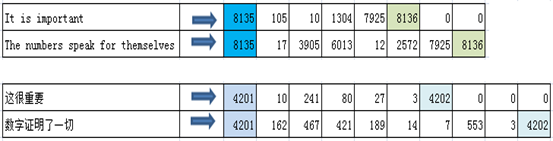


### 12.2.1 下载数据
1）导入需要的库。

In [1]:
import os
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pprint import pprint
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_datasets as tfds
print(tf.__version__)

2.0.0


2）设置输出日志级别  
为了避免TensorFlow输出不必要的信息，这里将改变logging等级。在TensorFlow 2里头因为tf.logging被弃用（deprecated），可以直接用logging模块来完成这件事情。

In [6]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
#让numpy不要显示科学记号
np.set_printoptions(suppress=True)

3）定义保存数据路径、字典存放文件等信息。

In [7]:
output_dir = "nmt"
en_vocab_file = os.path.join(output_dir, "en_vocab")
zh_vocab_file = os.path.join(output_dir, "zh_vocab")
checkpoint_path = os.path.join(output_dir, "checkpoints")
log_dir = os.path.join(output_dir, 'logs')
download_dir = "tensorflow-datasets/downloads"

if not os.path.exists(output_dir):
  os.makedirs(output_dir)


4）下载数据

In [110]:
#查看tfds有哪些数据集可以使用,显示后10个数据集
tfds.list_builders()[-10:]

['wikipedia',
 'wmt14_translate',
 'wmt15_translate',
 'wmt16_translate',
 'wmt17_translate',
 'wmt18_translate',
 'wmt19_translate',
 'wmt_t2t_translate',
 'wmt_translate',
 'xnli']

In [8]:
#这里我们使用wmt19_translate数据集
tmp_builder = tfds.builder("wmt19_translate/zh-en")
pprint(tmp_builder.subsets)

{NamedSplit('train'): ['newscommentary_v14',
                       'wikititles_v1',
                       'uncorpus_v1',
                       'casia2015',
                       'casict2011',
                       'casict2015',
                       'datum2015',
                       'datum2017',
                       'neu2017'],
 NamedSplit('validation'): ['newstest2018']}


5）定义下载配置文件。定义下载数据集的范围，并下载数据。

In [9]:
config = tfds.translate.wmt.WmtConfig(
  version=tfds.core.Version('0.0.3', experiments={tfds.core.Experiment.S3: False}),
  language_pair=("zh", "en"),
  subsets={
    tfds.Split.TRAIN: ["newscommentary_v14"]
  }
)
builder = tfds.builder("wmt_translate", config=config)
builder.download_and_prepare(download_dir=download_dir)

### 12.2.2 分割数据
	虽然我们只下载了一个新闻评论的数据集，里头还是有超过30万笔的中英平行句子。为了减少训练所需的时间，使用tfds.Split定义一个将此数据集切成多个部分的split。  
 1）使用split进行划分。  

In [10]:
train_perc = 20
val_prec = 1
drop_prec = 100 - train_perc - val_prec

split = tfds.Split.TRAIN.subsplit([train_perc, val_prec, drop_prec])
split

(NamedSplit('train')(tfds.percent[0:20]),
 NamedSplit('train')(tfds.percent[20:21]),
 NamedSplit('train')(tfds.percent[21:100]))

2）生成训练和验证数据集。将前两个splits拿来当作训练以及验证集，其余暂不使用。

In [11]:
examples = builder.as_dataset(split=split, as_supervised=True)
train_examples, val_examples, _ = examples
print(train_examples)
print(val_examples)

<_OptionsDataset shapes: ((), ()), types: (tf.string, tf.string)>
<_OptionsDataset shapes: ((), ()), types: (tf.string, tf.string)>


3）查看数据结构。我们将这些Tensors实际储存的字串利用numpy（）取出并译码。

In [94]:
sample_examples = []
num_samples = 2
c=1
for en_t, zh_t in train_examples.take(num_samples):
  en = en_t.numpy().decode("utf-8")
  zh = zh_t.numpy().decode("utf-8")
  
  print('-' * 10 + '第'+str(c)+'对语句'+"-"*10)
  print(en)
  print(zh)
  c+=1
  
  # 这些数据将用来简单评估模型的训练情况
  sample_examples.append((en, zh))

----------第1对语句----------
Making Do With More
多劳应多得
----------第2对语句----------
If the Putins, Erdoğans, and Orbáns of the world want to continue to benefit economically from the open international system, they cannot simply make up their own rules.
如果普京、埃尔多安和欧尔班希望继续享有开放国际体系提供的经济利益，就不能简单地制定自己的规则。


In [118]:
sample_examples

[('Making Do With More', '多劳应多得'),
 ('If the Putins, Erdoğans, and Orbáns of the world want to continue to benefit economically from the open international system, they cannot simply make up their own rules.',
  '如果普京、埃尔多安和欧尔班希望继续享有开放国际体系提供的经济利益，就不能简单地制定自己的规则。')]

## 12.2.3 创建英文语料字典
	就跟大多数NLP项目相同，有了原始的中英句子,对单词进行分词，然后为其建立字典来将每个词汇转成索引（Index）。tfds.features.text底下的SubwordTextEncoder提供非常方便的API,让我们扫过整个训练数据集并建立字典，字典大小设置为8192（即2**13）  
1）从en_vocab_file读取数据。

In [16]:
%%time
try:
  subword_encoder_en = tfds.features.text.SubwordTextEncoder.load_from_file(en_vocab_file)
  print(f"导入已建立的字典： {en_vocab_file}")
except:
  print("沒有已建立的字典，重新建立。")
  subword_encoder_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
      (en.numpy() for en, _ in train_examples), 
      target_vocab_size=2**13) # 字典大小为8192
  
  # 保存字典资料，便于下次使用
  subword_encoder_en.save_to_file(en_vocab_file)
  

print(f"字典大小：{subword_encoder_en.vocab_size}")
print(f"前10个 subwords：{subword_encoder_en.subwords[:10]}")
print()

导入已建立的字典： nmt/en_vocab
字典大小：8135
前10个 subwords：[', ', 'the_', 'of_', 'to_', 'and_', 's_', 'in_', 'a_', 'that_', 'is_']

CPU times: user 60 ms, sys: 12 ms, total: 72 ms
Wall time: 69.3 ms


这里subword_encoder_en利用GNMT当初推出的wordpieces来进行断词，而简单来说其产生的子词（subword）介于这两者之间：用英文字母分隔的断词（character-delimited）用空白分隔的断词（word-delimited）在扫过所有英文句子以后，subword_encoder_en建立一个有8135个子词的字典。我们可以用该字典来帮我们将一个英文句子转成对应的索引序列（index sequence）  
2）使用subword_encoder_en.encode简单示例。

In [17]:
sample_string = 'Shanghai is beautiful.'
indices = subword_encoder_en.encode(sample_string)
indices

[2467, 232, 3157, 7911, 10, 2942, 7457, 1163, 7925]

3）根据索引进行还原

In [19]:
print("{0:10}{1:6}".format("Index", "Subword"))
print("-" * 15)
for idx in indices:
  subword = subword_encoder_en.decode([idx])
  print('{0:5}{1:6}'.format(idx, ' ' * 5 + subword))

Index     Subword
---------------
 2467     Sha
  232     ng
 3157     hai
 7911      
   10     is 
 2942     bea
 7457     uti
 1163     ful
 7925     .


当subword tokenizer遇到从没出现过在字典里的词汇，会将该词拆成多个子词（subwords）。比方说上面句中的beautiful就被拆成bea uti ful。这也是为何这种断词方法比较不怕没有出现过在字典里的字（out-of-vocabulary words）。 另外别在意我为了对齐写的print语法。重点是我们可以用subword_encoder_en的decode函式再度将索引数字转回其对应的子词。编码与译码是2个完全可逆（invertable）的操作：

In [20]:
sample_string = 'Shanghai is beautiful.'
indices = subword_encoder_en.encode(sample_string)
decoded_string = subword_encoder_en.decode(indices)
assert decoded_string == sample_string
pprint((sample_string, decoded_string))

('Shanghai is beautiful.', 'Shanghai is beautiful.')


### 12.2.4 创建中文语料字典
	创建中文语料字典与英文类似，不过在分词时需要指明个中文字就是字典的一个单位，通过设置max_subword_length=1来实现。具体代码如下：

In [21]:
%%time
try:
  subword_encoder_zh = tfds.features.text.SubwordTextEncoder.load_from_file(zh_vocab_file)
  print(f"导入已建立的字典： {zh_vocab_file}")
except:
  print("沒有已建立的字典，重新开始。")
  subword_encoder_zh = tfds.features.text.SubwordTextEncoder.build_from_corpus(
      (zh.numpy() for _, zh in train_examples), 
      target_vocab_size=2**13, # 有需要可以调整字典大小
      max_subword_length=1) # 每一个中文字就是字典的一个单位
  
  # 保存字典便于下次使用
  subword_encoder_zh.save_to_file(zh_vocab_file)

print(f"字典大小：{subword_encoder_zh.vocab_size}")
print(f"前10个 subwords：{subword_encoder_zh.subwords[:10]}")
print()

导入已建立的字典： nmt/zh_vocab
字典大小：4201
前10个 subwords：['的', '，', '。', '国', '在', '是', '一', '和', '不', '这']

CPU times: user 32 ms, sys: 8 ms, total: 40 ms
Wall time: 41.4 ms


在使用build_from_corpus函式扫过整个中文数据集时，我们将max_subword_length参数设置为1。这样可以让每个汉字都会被视为字典里头的一个单位。毕竟跟英文的abc字母不同，一个汉字代表的意思可多得多了。而且如果使用n-gram的话可能的词汇组合太多，在小数据集的情况非常容易遇到不存在字典里头的字。 另外所有汉字也就大约4000 ~ 5000个可能，作为一个分类问题（classification problem）还是可以接受的。 让我们挑个中文句子来测试看看：

In [22]:
sample_string = sample_examples[0][1]
indices = subword_encoder_zh.encode(sample_string)
print(sample_string)
print(indices)

多劳应多得
[48, 557, 116, 48, 81]


我们把中英文断词及字典的部分都搞定了。现在给定一个例子（example，在这边以及后文指的都是一组包含同语义的中英平行句子），我们都能将其转换成对应的索引序列了：

In [24]:
en = "The eurozone’s collapse forces a major realignment of European politics."
zh = "欧元区的瓦解强迫欧洲政治进行一次重大改组。"

# 将文字转换成 subword indices
en_indices = subword_encoder_en.encode(en)
zh_indices = subword_encoder_zh.encode(zh)

print("[英中原文]（转换前）")
print(en)
print(zh)
print()
print('-' * 40)
print()
print("[英中序列]（转换后）")
print(en_indices)
print(zh_indices)

[英中原文]（转换前）
The eurozone’s collapse forces a major realignment of European politics.
欧元区的瓦解强迫欧洲政治进行一次重大改组。

----------------------------------------

[英中序列]（转换后）
[17, 965, 11, 6, 1707, 676, 8, 211, 2712, 6683, 249, 3, 85, 1447, 7925]
[45, 206, 171, 1, 847, 197, 236, 604, 45, 90, 17, 130, 102, 36, 7, 284, 80, 18, 212, 265, 3]


现在对语句进行了分词并进行索引化，然后构建词与索引的字典关系，当然，经过这样处理后是否就可以作为Transormer的输入呢？还需最后一般，添加一个语句开始、结束标识符。
接下来我们针对这些索引序列（index sequence）再做一些后续处理

## 12.2.5 定义编码函数
	在处理序列数据时我们时常会在一个序列的前后各加入一个特殊的标识符(token)，以标记该序列的开始与结束，而它们常有许多不同的称呼  
	开始token、Begin of Sentence、BOS、  
	结束token、End of Sentence、EOS、  
	这边我们定义了一个将被tf.data.Dataset使用的encode函式，它的输入是一笔包含2个string Tensors的例子，输出则是2个包含BOS / EOS的索引序列。


1、给添加每个语句的开始、结束标识符

In [25]:
def encode(en_t, zh_t):
  # 序列索引从0开始，
  # 我们可以使用 subword_encoder_en.vocab_size 这个值作为BOS的索引值
  # 用 subword_encoder_en.vocab_size + 1 作为EOS 的索引值
  en_indices = [subword_encoder_en.vocab_size] + subword_encoder_en.encode(
      en_t.numpy()) + [subword_encoder_en.vocab_size + 1]
  # 同理，使用中文字典的最后一个索引 + 1
  zh_indices = [subword_encoder_zh.vocab_size] + subword_encoder_zh.encode(
      zh_t.numpy()) + [subword_encoder_zh.vocab_size + 1]
  
  return en_indices, zh_indices

因为tf.data.Dataset里头都是在操作Tensors（而非Python字串），所以这个encode函式预期的输入也是TensorFlow里的Eager Tensors。但只要我们使用numpy（）将Tensor里的实际字串取出以后，做的事情就跟上一节完全相同。 让我们从训练集里随意取一组中英的Tensors来看看这个函式的实际输出：

In [26]:
en_t, zh_t = next(iter(train_examples))
en_indices, zh_indices = encode(en_t, zh_t)
print('英文 BOS 的 index：', subword_encoder_en.vocab_size)
print('英文 EOS 的 index：', subword_encoder_en.vocab_size + 1)
print('中文 BOS 的 index：', subword_encoder_zh.vocab_size)
print('中文 EOS 的 index：', subword_encoder_zh.vocab_size + 1)

print('\n输入为2个 Tensors：')
pprint((en_t, zh_t))
print('-' * 15)
print('输出为2个索引序列：')
pprint((en_indices, zh_indices))

英文 BOS 的 index： 8135
英文 EOS 的 index： 8136
中文 BOS 的 index： 4201
中文 EOS 的 index： 4202

输入为2个 Tensors：
(<tf.Tensor: id=282, shape=(), dtype=string, numpy=b'Making Do With More'>,
 <tf.Tensor: id=283, shape=(), dtype=string, numpy=b'\xe5\xa4\x9a\xe5\x8a\xb3\xe5\xba\x94\xe5\xa4\x9a\xe5\xbe\x97'>)
---------------
输出为2个索引序列：
([8135, 4682, 19, 717, 7911, 298, 2701, 7980, 8136],
 [4201, 48, 557, 116, 48, 81, 4202])


你可以看到不管是英文还是中文的索引序列，前面都加了一个代表BOS的索引（分别为8135与4201），最后一个索引则代表EOS（分别为8136与4202） 但如果我们将encode函式直接套用到整个训练数据集时会产生“AttributeError: 'Tensor' object has no attribute 'numpy'”的错误信息。

这是因为目前tf.data.Dataset.map函式里头的计算是在计算图模式（Graph mode）下执行，所以里头的Tensors并不会有Eager Execution下才有的numpy属性。 解法是使用tf.py_function将我们刚刚定义的encode函式包成一个以eager模式执行的TensorFlow Op：

2.把encode的结果转换为tf.Tensor格式的数据  
	目前tf.data.Dataset.map函式里的计算是在计算图模式（Graph mode）下执行，而Tensors并不会有Eager Execution下才有的numpy属性。解法是使用tf.py_function将我们刚刚定义的encode函式包转换成一个以eager模式执行的操作，即把encode的结果转换为tf.Tensor格式的数据即可。


In [28]:
def tf_encode(en_t, zh_t):
  # 在 `tf_encode` 函式的 `en_t` 与 `zh_t` 都不是 Eager Tensors
  # 要到`tf.py_funtion` 里才是
  # 另外因为索引都是整数，所以使用 `tf.int64`
  return tf.py_function(encode, [en_t, zh_t], [tf.int64, tf.int64])

# `tmp_dataset` 为说明用資料集，说明完所有重要的 func，
# 重新建立一个正式的 `train_dataset`
tmp_dataset = train_examples.map(tf_encode)
en_indices, zh_indices = next(iter(tmp_dataset))
print(en_indices)
print(zh_indices)

tf.Tensor([8135 4682   19  717 7911  298 2701 7980 8136], shape=(9,), dtype=int64)
tf.Tensor([4201   48  557  116   48   81 4202], shape=(7,), dtype=int64)


### 12.2.6过滤数据
	为使训练Transformer更简单一些，这里将长度超过40个tokens的序列都去掉。通过定义一个布尔（boolean）函式，其输入为一个包含两个英中序列en，zh的例子，并在只有这2个序列的长度都小于40的时候回传真值（True）。

In [29]:
MAX_LENGTH = 40

def filter_max_length(en, zh, max_length=MAX_LENGTH):
  # en, zh 分別代表英文与中文的索引序列
  return tf.logical_and(tf.size(en) <= max_length,
                        tf.size(zh) <= max_length)

# tf.data.Dataset.filter(func) 只回传 func为真的例子
tmp_dataset = tmp_dataset.filter(filter_max_length)

简单检查是否有序列超过我们指定的长度，顺便计算过滤掉过长序列后剩馀的训练集笔数：

In [30]:
# 因数据量小可以这样统计总数
num_examples = 0
for en_indices, zh_indices in tmp_dataset:
  cond1 = len(en_indices) <= MAX_LENGTH
  cond2 = len(zh_indices) <= MAX_LENGTH
  assert cond1 and cond2
  num_examples += 1

print(f"所有英文與中文序列長度都不超过{MAX_LENGTH}个 tokens")
print(f"训练集共有 {num_examples} 笔数据")

所有英文與中文序列長度都不超过40个 tokens
训练集共有 29914 笔数据


过滤掉较长句子后还有接近3万笔的训练例子，看来不用担心数据太少。 最后值得注意的是每个例子里的索引序列长度不一，这在建立batch时可能会发生问题。不过别担心，轮到padded_batch函式出场了：

In [31]:
BATCH_SIZE = 64
# 將 batch 裡的所有序列都 pad 到同樣長度
tmp_dataset = tmp_dataset.padded_batch(BATCH_SIZE, padded_shapes=([-1], [-1]))
en_batch, zh_batch = next(iter(tmp_dataset))
print("英文索引序列的 batch")
print(en_batch)
print('-' * 20)
print("中文索引序列的 batch")
print(zh_batch)

英文索引序列的 batch
tf.Tensor(
[[8135 4682   19 ...    0    0    0]
 [8135   17  965 ... 8136    0    0]
 [8135 6602    2 ...    0    0    0]
 ...
 [8135 1097  270 ...    0    0    0]
 [8135 1713   70 ...    0    0    0]
 [8135 2731 4553 ...    0    0    0]], shape=(64, 34), dtype=int64)
--------------------
中文索引序列的 batch
tf.Tensor(
[[4201   48  557 ...    0    0    0]
 [4201   45  206 ...    0    0    0]
 [4201   58    5 ...  683    3 4202]
 ...
 [4201   29  120 ...    0    0    0]
 [4201  297  161 ...    0    0    0]
 [4201  279  149 ... 4202    0    0]], shape=(64, 40), dtype=int64)


### 12.2.7创建训练集和验证集
	padded_batch函式能帮我们将每个batch里头的序列都补0到跟当下batch里头最长的序列一样长。比方说英文batch里最长的序列为34；而中文batch里最长的序列则长达40个tokens，刚好是我们前面设定过的序列长度上限。现在让我们从头建立训练集与验证集，顺便看看这些中英句子是如何被转换成它们的最终形态的。

In [32]:
BATCH_SIZE = 128
BUFFER_SIZE = 15000

#训练集
train_dataset = (train_examples  # 输出：(英文句子, 中文句子)
                 .map(tf_encode) # 输出：(英文索引序列, 中文索引序列)
                 .filter(filter_max_length) # 同上，且序列长度不超过40
                 .cache() # 便于更快读取数据
                 .shuffle(BUFFER_SIZE) # 打乱数据
                 .padded_batch(BATCH_SIZE, # 使batch中的句子保持一样的长度
                               padded_shapes=([-1], [-1]))
                 .prefetch(tf.data.experimental.AUTOTUNE)) # 加速
# 验证集
val_dataset = (val_examples
               .map(tf_encode)
               .filter(filter_max_length)
               .padded_batch(BATCH_SIZE, 
                             padded_shapes=([-1], [-1])))

构训练数据集时我们还添加了些没提过的函式。它们的用途大都是用来提高输入效率，并不会影响到输出格式。如果你想深入了解这些函式的运作方式，可以参考tf.data的官方文档。现在让我们看看最后建立出来的数据集长什么样子。

In [99]:
en_batch, zh_batch = next(iter(train_dataset))
print("en_batch的形状:{},zh_batch的形状:{}".format(en_batch.shape,zh_batch.shape))
print("英文索引序列的 batch样例")
print(en_batch[:2])
print('-' * 20)
print("中文索引序列的 batch样例")
print(zh_batch[:2])


en_batch的形状:(128, 37),zh_batch的形状:(128, 40)
英文索引序列的 batch样例
tf.Tensor(
[[8135   17 7088 5507 2489 2188 2168 2542    8  649  997 1685  160 1882
  5261 7911   37 6309   59 7925 8136    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [8135 2699 3692 7445 7911 2833   33 6131 7911 3381 1394 7980 8136    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]], shape=(2, 37), dtype=int64)
--------------------
中文索引序列的 batch样例
tf.Tensor(
[[4201 4023 4010 4015 4029 4010  923  935  111    9  735    2  692  178
  2033  413  146   74  372   81  337  337  374    1  136  994    3 4202
     0    0    0    0    0    0    0    0    0    0    0    0]
 [4201   15  257  375  342  163   91    6    7   31  274  489  123  143
  4202    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]], shape=(2, 40), dtype=int64)


## 12.3 构建Transformer模型
	Transformer是大多预训练模型的核心，其重要性就不言而喻了。为帮助大家更好理解，这里我们使用TensorFlow最新版（2+版本）进行数据预处理，并用它构建Transformer，最后进行训练和评估。
### 12.3.1 Transformer架构图
	Transformer的原理在第5章已详细介绍过，就不详细说明了，这里只简单提供其核心框架，如下图所示。

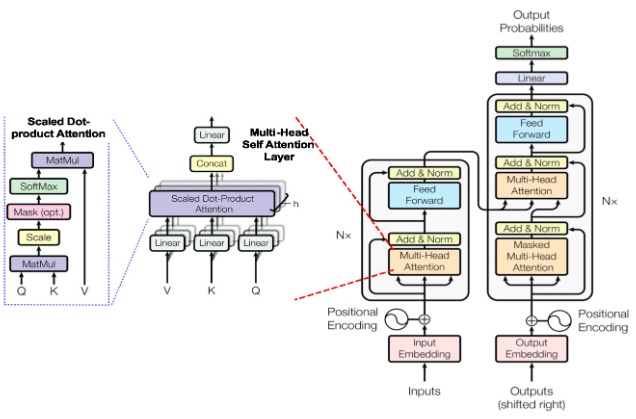

### 12.3.2架构说明
	从上图不难看出，Transformer由一个编码器（Encoder）和一个解码器（Decoder）构成，而Encoder又由N个Encoder layer构成，Decoder由N个Decoder layers 构成。这些模块之间的逻辑关系如下，后面我们就按照这个逻辑关系来构建Transformer模型。

### 12.3.3构建scaled_dot_product_attention模块
	构建图12-2 中的注意力权重核心模块scaled dot product attention。

In [101]:
def scaled_dot_product_attention(q, k, v, mask):
  """计算注意力权重.
  q, k, v 必须有匹配的维度.
  参数:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  返回值:
    output, attention_weights
  """
  # 将`q`与`k`做点积，再scale
  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  dk = tf.cast(tf.shape(k)[-1], tf.float32)  # 获取seq_k序列长度
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)  # scale by sqrt(dk)

  # 将掩码加入logits
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # 使用softmax 激活函数
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
  
  # 对v做加权平均(weighted average)
  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

### 12.3.4构建MultiHeadAttention模块
	对q、k、v输入一个前馈神经网络，然后在scaled_dot_product_attention的基础上构建多头注意力模块。

In [102]:
# 初始化时指定输出维度及多头注意数目`d_model` & `num_heads，
# 运行时输入 `v`, `k`, `q` 以及 `mask`
# 输出与scaled_dot_product_attention 函式一样有两个：
# output.shape            == (batch_size, seq_len_q, d_model)
# attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
class MultiHeadAttention(tf.keras.layers.Layer):
  # 初始化相关参数
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads # 指定要将`d_model`拆成几个heads
    self.d_model = d_model # 在split_heads之前的维度
    
    assert d_model % self.num_heads == 0  # 确保能整除或平分
    
    self.depth = d_model // self.num_heads  # 每个head里子词新的维度
    
    self.wq = tf.keras.layers.Dense(d_model)  # 分別给q, k, v 做线性转换 
    self.wk = tf.keras.layers.Dense(d_model)  # 这里并没有指定激活函数
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)  # 多heads拼接后做线性转换
  
  # 划分成多头机制
  def split_heads(self, x, batch_size):
    """将最后一个维度拆分为(num_heads, depth).
    转置后的形状为 (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
  
  # multi-head attention 的实际执行流程，注意参数顺序
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    # 将输入的 q, k, v 都各自做一次线性转换到 `d_model`维空间
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    #将最后一个`d_model` 维度拆分成 `num_heads` 个`depth` 维度
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # 利用广播机制(broadcasting )让每个句子的每个head的 qi, ki, vi都各自实现注意力机制
    # 输出多一个表示num_heads的维度
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    
    # 与`split_heads` 相反，先做 transpose 再做 reshape
    # 将`num_heads` 个`depth` 维度拼接成原来的`d_model`维度
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
    # (batch_size, seq_len_q, num_heads, depth)
    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model)) 
    # (batch_size, seq_len_q, d_model)

    # 实现最后一个线性转换
    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

### 12.3.5构建point_wise_feed_forward_network
	构建Encoder及Decoder中的前馈神经网络（feed forward network）模块。

In [103]:
# 创建Transformer 中的Encoder / Decoder layer 都用到的Feed Forward组件
def point_wise_feed_forward_network(d_model, dff):
  
  # 这里FFN 对输入做两个线性转换，中间加一个ReLU激活函数
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

### 12.3.6构建EncoderLayer模块
	由MHA,dropout，norm及FFN构成一个Encoder Layer模块。

In [112]:
# Encoder有N个 EncoderLayers，而每个EncoderLayer 又有两个sub-layers即MHA & FFN
class EncoderLayer(tf.keras.layers.Layer):
  # dropout rate设为0.1
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    # 一个sub-layer使用一个layer norm
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    # 一个sub-layer使用一个 dropout layer
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  # `dropout在训练以及测试的作用有所不同
  def call(self, x, training, mask):
    # 除了 `attn`，其他张量的形状都为(batch_size, input_seq_len, d_model)
    # attn.shape == (batch_size, num_heads, input_seq_len, input_seq_len)
    
    # sub-layer 1: MHA
    # Encoder 利用注意力机制关注自己当前的序列，因此 v, k, q 全部都是自己
    # 需要用 padding mask 来遮住输入序列中的 <pad> token
    attn_output, attn = self.mha(x, x, x, mask)  
    attn_output = self.dropout1(attn_output, training=training) 
    out1 = self.layernorm1(x + attn_output)  
    
    # sub-layer 2: FFN
    ffn_output = self.ffn(out1) 
    ffn_output = self.dropout2(ffn_output, training=training)  
    out2 = self.layernorm2(out1 + ffn_output)
    
    return out2

### 12.3.7构建Encoder模块
	定义输入嵌入（Embedding）及位置编码（pos_encoding），连接n个EncoderLayer构成Encoder模块。

In [105]:
class Encoder(tf.keras.layers.Layer):
  # 参数num_layers: 确定有几个EncoderLayers
  # 参数input_vocab_size: 用来把索引转换为词嵌入(Embedding)向量
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(input_vocab_size, self.d_model)
    
    # 创建`num_layers` 个EncoderLayers
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):
    # 输入的 x.shape == (batch_size, input_seq_len)
    # 以下各layer 的输出都是(batch_size, input_seq_len, d_model)
    input_seq_len = tf.shape(x)[1]
    
    # 将2维的索引序列转成3维的词嵌入张量，并乘上sqrt(d_model)
    # 再加上对应长度的位置编码
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :input_seq_len, :]


    x = self.dropout(x, training=training)
    
    # 通过N个EncoderLayer构建Encoder
    for i, enc_layer in enumerate(self.enc_layers):
      x = enc_layer(x, training, mask)        
    
    return x 

### 12.3.8构建DecoderLayer模块
	DecoderLayer由MHA、Encoder输出的MHA及FFN构成。

In [106]:
# Decoder有N个DecoderLayer，
# 而DecoderLayer有三个sub-layers: 自注意的MHA,Encoder输出的MHA及FFN
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    # 3 个sub-layer
    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    # 每个sub-layer使用的LayerNorm
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    # 定义每个sub-layer使用的Dropout
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           combined_mask, inp_padding_mask):
    # 所有sub-layers的主要输出皆为 (batch_size, target_seq_len, d_model)
    # enc_output为Encoder输出序列，其形状为 (batch_size, input_seq_len, d_model)
    # attn_weights_block_1 形状为 (batch_size, num_heads, target_seq_len, target_seq_len)
    # attn_weights_block_2 形状为 (batch_size, num_heads, target_seq_len, input_seq_len)

    # sub-layer 1:Decoder layer需要 look ahead mask 以及对输出序列的padding mask 
    # 以此来避免前面已生成的子词关注到未來的子词以及 <pad>
    attn1, attn_weights_block1 = self.mha1(x, x, x, combined_mask)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    # sub-layer 2: Decoder layer关注Encoder 的最后输出
    # 同样需要对Encoder的输出使用用padding mask避免关注到 <pad>
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, inp_padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    # sub-layer 3: FFN 部分跟 Encoder layer 完全一样
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    
    return out3, attn_weights_block1, attn_weights_block2

### 12.3.9构建DecoderLayer模块
	Decoder layer本来就只跟Encoder layer差在一个MHA，而这逻辑被包起来以后呼叫它的Decoder做的事情就跟Encoder基本上没有两样了。
	在Decoder里头我们只需要建立一个专门给中文用的词嵌入层以及位置编码即可。我们在呼叫每个Decoder layer的时候也顺便把其注意权重存下来，方便我们了解模型训练完后是怎么做翻译的。

In [107]:
class Decoder(tf.keras.layers.Layer):
  # 初始化参数与Encoder基本相同，所不同的是`target_vocab_size` 而非 `inp_vocab_size`
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, 
               rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    
    #为中文（即目标语言）构建词嵌入层
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(target_vocab_size, self.d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
  
  # 调用的参数与DecoderLayer相同
  def call(self, x, enc_output, training, 
           combined_mask, inp_padding_mask):
    
    tar_seq_len = tf.shape(x)[1]
    attention_weights = {}  # 用于存放每个Decoder layer 的注意力权重
    
    # 这与Encoder做的事情完全一样
    x = self.embedding(x)  # (batch_size, tar_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :tar_seq_len, :]
    x = self.dropout(x, training=training)

    
    for i, dec_layer in enumerate(self.dec_layers):
      x, block1, block2 = dec_layer(x, enc_output, training,
                                    combined_mask, inp_padding_mask)
      
      # 将从每个 Decoder layer 获取的注意力权重全部存下來回传，方便后续观察
      attention_weights['decoder_layer{}_block1'.format(i + 1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i + 1)] = block2
    
    # x.shape == (batch_size, tar_seq_len, d_model)
    return x, attention_weights

### 12.3.10构建Transformer模型
	Encoder和Decoder构成Transformer。

In [100]:
# Transformer 之上沒有其他层了，我們使用tf.keras.Model构建模型
class Transformer(tf.keras.Model):
  # 初始化参数包括Encoder 和Decoder 模块涉及的超参数以及中英字典数目等
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, rate)
    # 这个FFN 输出跟中文字典一样大的logits数，通过softmax后表示每个中文字出现的概率
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
  
  # enc_padding_mask 跟 dec_padding_mask 都是英文序列的 padding mask，
  # 只是一个给Encoder layer的MHA用，一个是给Decoder layer 的MHA 2使用
  def call(self, inp, tar, training, enc_padding_mask, 
           combined_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, combined_mask, dec_padding_mask)
    
    # Decoder 输出通过最后一个全连接层(linear layer)
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

被输入Transformer的多个2维英文张量inp会一路通过Encoder里头的词嵌入层，位置编码以及N个Encoder layers后被转换成Encoder输出enc_output，接着对应的中文序列tar则会在Decoder里头走过相似的旅程并在每一层的Decoder layer利用MHA 2关注Encoder的输出enc_output，最后被Decoder输出。

而Decoder的输出dec_output则会通过Final linear layer，被转成进入Softmax前的logits final_output，其logit的数目则跟中文字典里的子词数相同。

因为Transformer把Decoder也包起来了，现在我们连Encoder输出enc_output也不用管，只要把英文（来源）以及中文（目标）的索引序列batch丢入Transformer，它就会输出最后一维为中文字典大小的张量。第2维是输出序列，里头每一个位置的向量就代表着该位置的中文字的机率分布（事实上通过softmax才是，但这边先这样说方便你理解）： 

输入： 英文序列：（batch_size，inp_seq_len）  
中文序列：（batch_size，tar_seq_len）  
输出： 生成序列：（batch_size，tar_seq_len，target_vocab_size）  
让我们马上建一个Transformer，并假设我们已经准备好用demo数据来训练它做英翻中：

### 12.3.11定义掩码函数
	为更好理解如何生成掩码，从一个简单实例开始。  
1.生成样例数据

In [38]:
demo_examples = [
    ("It is important.", "这很重要。"),
    ("The numbers speak for themselves.", "数字证明了一切。"),
]
pprint(demo_examples)

[('It is important.', '这很重要。'),
 ('The numbers speak for themselves.', '数字证明了一切。')]


2.生成transformer格式数据

In [39]:
batch_size = 2
demo_examples = tf.data.Dataset.from_tensor_slices((
    [en for en, _ in demo_examples], [zh for _, zh in demo_examples]
))

# 將兩個句子透過之前定義的字典轉換成子詞的序列（sequence of subwords）
# 并添加 padding token: <pad> 來确保 batch里的句子有一样长度
demo_dataset = demo_examples.map(tf_encode)\
  .padded_batch(batch_size, padded_shapes=([-1], [-1]))

# 取出这个 demo dataset 里为一个batch
inp, tar = next(iter(demo_dataset))
print('inp:', inp)
print('' * 10)
print('tar:', tar)

inp: tf.Tensor(
[[8135  105   10 1304 7925 8136    0    0]
 [8135   17 3905 6013   12 2572 7925 8136]], shape=(2, 8), dtype=int64)

tar: tf.Tensor(
[[4201   10  241   80   27    3 4202    0    0    0]
 [4201  162  467  421  189   14    7  553    3 4202]], shape=(2, 10), dtype=int64)


3.定义生成掩码函数

In [42]:
def create_padding_mask(seq):
  # padding mask 的工作就是把索引序列中為 0 的位置設為 1
  mask = tf.cast(tf.equal(seq, 0), tf.float32)
  return mask[:, tf.newaxis, tf.newaxis, :] #　broadcasting

inp_mask = create_padding_mask(inp)
inp_mask

<tf.Tensor: id=437865, shape=(2, 1, 1, 8), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0., 0., 1., 1.]]],


       [[[0., 0., 0., 0., 0., 0., 0., 0.]]]], dtype=float32)>

4.把输入数据转换为Embedding向量

In [45]:
# + 2 是因為我們額外加了 <start> 以及 <end> tokens
vocab_size_en = subword_encoder_en.vocab_size + 2
vocab_size_zh = subword_encoder_zh.vocab_size + 2

# 为了方便demo，将词汇转换到一个4维的词嵌入空间
d_model = 4
embedding_layer_en = tf.keras.layers.Embedding(vocab_size_en, d_model)
embedding_layer_zh = tf.keras.layers.Embedding(vocab_size_zh, d_model)

emb_inp = embedding_layer_en(inp)
emb_tar = embedding_layer_zh(tar)
emb_inp, emb_tar

(<tf.Tensor: id=437901, shape=(2, 8, 4), dtype=float32, numpy=
 array([[[ 0.00265089, -0.04667675,  0.03804572, -0.01895241],
         [-0.03157516,  0.04903611,  0.01949519,  0.03384198],
         [-0.02683893,  0.04426588,  0.04832116,  0.03428404],
         [-0.04732779, -0.01591169,  0.00208367, -0.01523191],
         [ 0.01373035, -0.03212922,  0.02969117, -0.04733359],
         [ 0.02099237,  0.00753694, -0.02888801, -0.01465794],
         [ 0.02066238, -0.04565375, -0.04908123, -0.04041936],
         [ 0.02066238, -0.04565375, -0.04908123, -0.04041936]],
 
        [[ 0.00265089, -0.04667675,  0.03804572, -0.01895241],
         [ 0.03977494, -0.0465814 , -0.04533129,  0.01168748],
         [ 0.01866969, -0.02601624, -0.03038559, -0.01913637],
         [ 0.01573206, -0.01339113, -0.0038677 , -0.0105889 ],
         [-0.02833319, -0.01579231, -0.01012477,  0.04539425],
         [-0.04417844,  0.01073499,  0.04789424,  0.02582378],
         [ 0.01373035, -0.03212922,  0.02969117, -0.

5.定义对目标输入的掩码函数

In [46]:
# 建立一个2 维矩阵，維度为 (size, size)，
# 其掩蔽為一个右上角的三角形
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

seq_len = emb_tar.shape[1] # 注意这次我们用中文的词嵌入張量 `emb_tar`
look_ahead_mask = create_look_ahead_mask(seq_len)
print("emb_tar:", emb_tar)
print("-" * 20)
print("look_ahead_mask", look_ahead_mask)

emb_tar: tf.Tensor(
[[[ 0.01810903 -0.03152271  0.01692872 -0.02074422]
  [ 0.03996461 -0.0387237  -0.00726188 -0.02946129]
  [ 0.04791793  0.03901002  0.02391765 -0.04674156]
  [ 0.0193624   0.03831762  0.02351922  0.03192753]
  [ 0.04098853  0.00375504  0.0470312   0.00083973]
  [ 0.00672518 -0.02529314 -0.04826082 -0.02197298]
  [ 0.03122735 -0.03200787  0.00946783  0.0189939 ]
  [ 0.04683008 -0.03738714 -0.01275484 -0.04845005]
  [ 0.04683008 -0.03738714 -0.01275484 -0.04845005]
  [ 0.04683008 -0.03738714 -0.01275484 -0.04845005]]

 [[ 0.01810903 -0.03152271  0.01692872 -0.02074422]
  [ 0.00858374 -0.00761633 -0.00715196  0.03089109]
  [ 0.01794245  0.0489574  -0.03328412  0.04054875]
  [ 0.00136274  0.01573837 -0.0337279  -0.02653014]
  [-0.02201243  0.01958663 -0.00785501 -0.04927301]
  [-0.04613362 -0.02273431 -0.0195735   0.00953114]
  [-0.04004059  0.03405197 -0.01185678  0.04649584]
  [ 0.03319022  0.03990693 -0.046237   -0.02667969]
  [ 0.00672518 -0.02529314 -0.04826082 -0.

6.定义配置编码函数

In [48]:
# 以下直接參考 TensorFlow 官方 tutorial 
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  sines = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  cosines = np.cos(angle_rads[:, 1::2])
  
  pos_encoding = np.concatenate([sines, cosines], axis=-1)
  
  pos_encoding = pos_encoding[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

7.根据以上生成的简单样例数据，测试一下Transformer

In [59]:
#定义几个超参数
num_layers = 1
d_model = 4
num_heads = 2
dff = 8

# + 2 为添加<start> & <end> 标识符
input_vocab_size = subword_encoder_en.vocab_size + 2
output_vocab_size = subword_encoder_zh.vocab_size + 2

# 预测时用前一个字预测后一个字
tar_inp = tar[:, :-1]
tar_real = tar[:, 1:]

# 使用源输入、目标输入的掩码，这里使用 `comined_mask` 把目标语言的两种MASK合而为一
inp_padding_mask = create_padding_mask(inp)
tar_padding_mask = create_padding_mask(tar_inp)
look_ahead_mask = create_look_ahead_mask(tar_inp.shape[1])
combined_mask = tf.math.maximum(tar_padding_mask, look_ahead_mask)

# 初始化第一个transformer
transformer = Transformer(num_layers, d_model, num_heads, dff, 
                          input_vocab_size, output_vocab_size)

# 导入英文、中文序列，查看Transformer 预测下个中文的結果
predictions, attn_weights = transformer(inp, tar_inp, False, inp_padding_mask, 
                                        combined_mask, inp_padding_mask)

print("tar:", tar)
print("-" * 20)
print("tar_inp:", tar_inp)
print("-" * 20)
print("tar_real:", tar_real)
print("-" * 20)
print("predictions:", predictions)

tar: tf.Tensor(
[[4201   10  241   80   27    3 4202    0    0    0]
 [4201  162  467  421  189   14    7  553    3 4202]], shape=(2, 10), dtype=int64)
--------------------
tar_inp: tf.Tensor(
[[4201   10  241   80   27    3 4202    0    0]
 [4201  162  467  421  189   14    7  553    3]], shape=(2, 9), dtype=int64)
--------------------
tar_real: tf.Tensor(
[[  10  241   80   27    3 4202    0    0    0]
 [ 162  467  421  189   14    7  553    3 4202]], shape=(2, 9), dtype=int64)
--------------------
predictions: tf.Tensor(
[[[ 0.0716907   0.02313289 -0.06107294 ... -0.08085196 -0.02475655
   -0.00949991]
  [ 0.05647633  0.02124603 -0.06365067 ... -0.08398581 -0.02732928
   -0.01114346]
  [ 0.07127554  0.03096525 -0.05082148 ... -0.07161332 -0.03431769
   -0.0129331 ]
  ...
  [ 0.05470427  0.02222914 -0.06204966 ... -0.0825286  -0.0290069
   -0.01181234]
  [ 0.03802809  0.01547571 -0.06671635 ... -0.08624943 -0.0252643
   -0.01108036]
  [ 0.00934073  0.0093632  -0.06114068 ... -0.07830

### 12.4定义损失函数
	这里基于交叉熵定义损失函数，先定义一个含交叉熵的对象，然后定义损失函数使用该对象。

1.定义一个损失对象  
基于一个交叉熵，创建一个损失对象

In [60]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

# 假设我们要处理是一个二分类binary classifcation， 0 、1 为标签值
real = tf.constant([1, 1, 0], shape=(1, 3), dtype=tf.float32)
pred = tf.constant([[0, 1], [0, 1], [0, 1]], dtype=tf.float32)
loss_object(real, pred)

<tf.Tensor: id=439310, shape=(3,), dtype=float32, numpy=array([0.31326166, 0.31326166, 1.3132616 ], dtype=float32)>

2. 定义损失函数  
	有了损失对象（loss_object）之后，还需要另外一个函式来建立掩码并加总序列里头，这里暂不包含` token位置的损失，后续将加上。

In [62]:
def loss_function(real, pred):
  # 这里mask将序列中不等于0的位置视为1，其余为0 
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  # 计算所有位置的交叉熵(cross entropy) ，但不汇总
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask  # 只计算非 <pad> 位置的损失 
  
  return tf.reduce_mean(loss_)

3. 定义两个评估指标

In [63]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

### 12.5 定义优化器
	优化器中学习率参数非常重要，这里我们采用一种动态变化的学习率。
### 12.5.1 定义一些超参数
	定义Encoder或Decoder层数、输入向量维度、FNN隐含层节点数等超参数。

In [64]:
num_layers = 4 
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = subword_encoder_en.vocab_size + 2
target_vocab_size = subword_encoder_zh.vocab_size + 2
dropout_rate = 0.1  # 初始值

print("input_vocab_size:", input_vocab_size)
print("target_vocab_size:", target_vocab_size)

input_vocab_size: 8137
target_vocab_size: 4203


## 12.5.2 定义优化器
	动态调整学习率，并采用自适应优化器Adam

In [65]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  # 预设值`warmup_steps` = 4000
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
  
# 将定制后的 learning rate schdeule输入Adam opt.
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

### 12.5.3 查看学习率的变化情况
	这里学习率参数不是固定不变，而是随着迭代次数而动态调整。

Text(0.5, 0, 'Train Step')

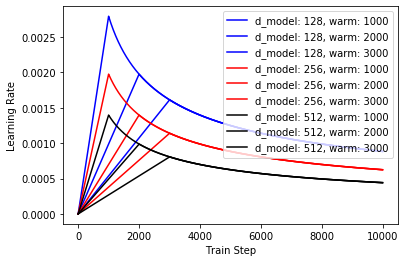

In [66]:
d_models = [128, 256, 512]
warmup_steps = [1000 * i for i in range(1, 4)]

schedules = []
labels = []
colors = ["blue", "red", "black"]
for d in d_models:
  schedules += [CustomSchedule(d, s) for s in warmup_steps]
  labels += [f"d_model: {d}, warm: {s}" for s in warmup_steps]

for i, (schedule, label) in enumerate(zip(schedules, labels)):
  plt.plot(schedule(tf.range(10000, dtype=tf.float32)), 
           label=label, color=colors[i // 3])

plt.legend()

plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### 12.6 训练模型
	由于数据量比较大，有条件的话，建议使用含GPU的服务器进行训练。
### 12.6.1 实例化transformer

In [113]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, dropout_rate)

print(f"""这Transformer 有 {num_layers} 层 Encoder / Decoder layers
d_model: {d_model}
num_heads: {num_heads}
dff: {dff}
input_vocab_size: {input_vocab_size}
target_vocab_size: {target_vocab_size}
dropout_rate: {dropout_rate}""")

这Transformer 有 4 层 Encoder / Decoder layers
d_model: 128
num_heads: 8
dff: 512
input_vocab_size: 8137
target_vocab_size: 4201
dropout_rate: 0.1


### 12.6.2 设置checkpoint
	设置checkpoint来定期储存/读取模型及optimizer是必备的。

In [71]:
# 方便比较不同实验/ 不同超参数设顶的结果
run_id = f"{num_layers}layers_{d_model}d_{num_heads}heads_{dff}dff_{train_perc}train_perc"
checkpoint_path = os.path.join(checkpoint_path, run_id)
log_dir = os.path.join(log_dir, run_id)

# tf.train.Checkpoint 把想要存下来的信息进行整合，方便存储和读取
# 保存模型及优化器（optimizer的状态
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

# ckpt_manager 将查看checkpoint_path 是否有 ckpt 里定义的信息
# 只保存最近5次checkpoints，其他自动刪除
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# 如果在checkpoint上发现有内容将读取
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  
  # 用来确定之前训练循环次数
  last_epoch = int(ckpt_manager.latest_checkpoint.split("-")[-1])
  print(f'已读取最新的checkpoint，模型已训练 {last_epoch} epochs。')
else:
  last_epoch = 0
  print("没有找到 checkpoint，重新开始训练。")

已读取最新的checkpoint，模型已训练 30 epochs。


### 12.6.3生成多种掩码
定义一个简单函式来产生所有的掩码

In [72]:
def create_masks(inp, tar):
  # 英文句子的 padding mask，给Encoder layer自注意力机制
  enc_padding_mask = create_padding_mask(inp)
  
  # 英文句子的 padding mask，给 Decoder layer的MHA 2 
  # 关注Encoder 输出序列用的
  dec_padding_mask = create_padding_mask(inp)
  
  # Decoder layer 的 MHA1 在做自注意力机制用的
  # `combined_mask` 是中文句子的 padding mask 跟 look ahead mask 的疊加
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

### 12.6.4定义训练模型函数
	定义训练模型的函数Train_step

In [73]:
@tf.function  # 使用TensorFlow 的 eager code优化模式
def train_step(inp, tar):
  # 用去尾的原始序列预测下一个字的序列
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  # 建立3 个掩码
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  # 记录Transformer 的所有运算过程以方便之后的梯度下降
  with tf.GradientTape() as tape:
    # 注意是导入`tar_inp`，并把`training` 参数设置为True
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    # 计算loss
    loss = loss_function(tar_real, predictions)

  # 使用Adam optimizer 更新Transformer 中的参数
  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  # 将loss 以及训练的acc等信息保存到TensorBoard 上
  train_loss(loss)
  train_accuracy(tar_real, predictions)

### 12.6.5训练模型
	训练模型，并保存训练结果。

In [75]:
#定义训练的循环次数
EPOCHS = 30
last_epoch=0
print(f"已训练 {last_epoch} epochs。")
print(f"剩余 epochs：{min(0, last_epoch - EPOCHS)}")


# 写入TensorBoard
summary_writer = tf.summary.create_file_writer(log_dir)

# 还要训练多少 epochs
for epoch in range(last_epoch, EPOCHS):
  start = time.time()
  
  # 重置TensorBoard的指标
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # 一个epoch 就是把我们定义的训练集逐个处理 
  for (step_idx, (inp, tar)) in enumerate(train_dataset):
    
    # 将数据导入Transformer，并计算损失值loss
    train_step(inp, tar)  

  # 每个epoch 完成就存一次  
  if (epoch + 1) % 1 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  # 將将loss 以及 accuracy 写入TensorBoard
  with summary_writer.as_default():
    tf.summary.scalar("train_loss", train_loss.result(), step=epoch + 1)
    tf.summary.scalar("train_acc", train_accuracy.result(), step=epoch + 1)
  
  print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))
  print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

已训练 0 epochs。
剩余 epochs：-30
Saving checkpoint for epoch 1 at nmt/checkpoints/4layers_128d_8heads_512dff_20train_perc/ckpt-31
Epoch 1 Loss 1.1249 Accuracy 0.4161
Time taken for 1 epoch: 151.75437664985657 secs

Saving checkpoint for epoch 2 at nmt/checkpoints/4layers_128d_8heads_512dff_20train_perc/ckpt-32
Epoch 2 Loss 1.1024 Accuracy 0.4193
Time taken for 1 epoch: 92.5037932395935 secs

Saving checkpoint for epoch 3 at nmt/checkpoints/4layers_128d_8heads_512dff_20train_perc/ckpt-33
Epoch 3 Loss 1.0806 Accuracy 0.4228
Time taken for 1 epoch: 73.45966386795044 secs

Saving checkpoint for epoch 4 at nmt/checkpoints/4layers_128d_8heads_512dff_20train_perc/ckpt-34
Epoch 4 Loss 1.0600 Accuracy 0.4261
Time taken for 1 epoch: 82.79908227920532 secs

Saving checkpoint for epoch 5 at nmt/checkpoints/4layers_128d_8heads_512dff_20train_perc/ckpt-35
Epoch 5 Loss 1.0428 Accuracy 0.4290
Time taken for 1 epoch: 67.15992593765259 secs

Saving checkpoint for epoch 6 at nmt/checkpoints/4layers_128d_8head

## 12.7 评估预测模型
	这里评估模型使用自定义的评估函数，具体请看如下详细代码。
### 12.7.1定义评估函数
	定义评估模型的函数。

In [76]:
# 给定一个英文句子，输出预测的中文索引序列及注意力权重字典
def evaluate(inp_sentence):
  
  #在英文句子前后分别加上<start>, <end>
  start_token = [subword_encoder_en.vocab_size]
  end_token = [subword_encoder_en.vocab_size + 1]
  
  # inp_sentence 是字符串，用Subword Tokenizer 将其变成子词的索引序列
  # 在前后加上 BOS / EOS
  inp_sentence = start_token + subword_encoder_en.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # Decoder 在第首先輸入是一个只包含一个中文 <start> token 的序列
  decoder_input = [subword_encoder_zh.vocab_size]
  output = tf.expand_dims(decoder_input, 0)  # 增加 batch维度
  
  # 一次生成一个中文字并将预测加到输入再导入Transformer
  for i in range(MAX_LENGTH):
    # 每生成的一个字就得产生新的掩蔽
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    

    # 取出序列中的最后一个distribution ，将其中最大的当做模型最新的预测字
    predictions = predictions[: , -1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # 遇到 <end> token 就停止回传，表示模型已生成完成
    if tf.equal(predicted_id, subword_encoder_zh.vocab_size + 1):
      return tf.squeeze(output, axis=0), attention_weights
    
    #将Transformer新预测中文索引加到输出序列中，使Decoder可以产生
    # 下个中文字的时候关注到最新的`predicted_id`
    output = tf.concat([output, predicted_id], axis=-1)

  # 将batch 的维度去掉后回传预测的中文索引序列
  return tf.squeeze(output, axis=0), attention_weights

### 12.7.2测试翻译几个简单语句
	使用新数据（一句英文）对模型进行英译汉的测试。

In [77]:
# 输入英文句子
sentence = "China, India, and others have enjoyed continuing economic growth."

# 获取预测中文索引序列
predicted_seq, _ = evaluate(sentence)

# 过滤掉 <start> & <end> tokens 并用中文的 subword tokenizer 将索引序列还原中文句子
target_vocab_size = subword_encoder_zh.vocab_size
predicted_seq_without_bos_eos = [idx for idx in predicted_seq if idx < target_vocab_size]
predicted_sentence = subword_encoder_zh.decode(predicted_seq_without_bos_eos)

print("sentence:", sentence)
print("-" * 20)
print("predicted_seq:", predicted_seq)
print("-" * 20)
print("predicted_sentence:", predicted_sentence)

sentence: China, India, and others have enjoyed continuing economic growth.
--------------------
predicted_seq: tf.Tensor(
[4201   16    4   37  386  101    8   34   32    4   33  110    5  104
  292  378   76   22   52  107   84    3], shape=(22,), dtype=int32)
--------------------
predicted_sentence: 中国、印度和其他国家都在持续推动经济增长。


考虑到这个Transformer不算巨大（约400万个参数），且模型训练时用的数据集不大的情况下，我们达到相当不错的结果，你说是吧？在这个例子里头该翻的词汇都翻了出来，句子本身也还算自然。

In [78]:
transformer.summary()

Model: "transformer_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_9 (Encoder)          multiple                  1834624   
_________________________________________________________________
decoder_5 (Decoder)          multiple                  1596288   
_________________________________________________________________
dense_297 (Dense)            multiple                  542187    
Total params: 3,973,099
Trainable params: 3,973,099
Non-trainable params: 0
_________________________________________________________________


## 12.8可视化注意力权重
	1）对模型在英 ->中翻译过程中形成的注意力权重可视化。

In [79]:
predicted_seq, attention_weights = evaluate(sentence)

# 这里自动选择最后一个Decoder layer 的 MHA 2，也就是Decoder 关注Encoder 的MHA
layer_name = f"decoder_layer{num_layers}_block2"

print("sentence:", sentence)
print("-" * 20)
print("predicted_seq:", predicted_seq)
print("-" * 20)
print("attention_weights.keys():")
for layer_name, attn in attention_weights.items():
  print(f"{layer_name}.shape: {attn.shape}")
print("-" * 20)
print("layer_name:", layer_name)

sentence: China, India, and others have enjoyed continuing economic growth.
--------------------
predicted_seq: tf.Tensor(
[4201   16    4   37  386  101    8   34   32    4   33  110    5  104
  292  378   76   22   52  107   84    3], shape=(22,), dtype=int32)
--------------------
attention_weights.keys():
decoder_layer1_block1.shape: (1, 8, 22, 22)
decoder_layer1_block2.shape: (1, 8, 22, 15)
decoder_layer2_block1.shape: (1, 8, 22, 22)
decoder_layer2_block2.shape: (1, 8, 22, 15)
decoder_layer3_block1.shape: (1, 8, 22, 22)
decoder_layer3_block2.shape: (1, 8, 22, 15)
decoder_layer4_block1.shape: (1, 8, 22, 22)
decoder_layer4_block2.shape: (1, 8, 22, 15)
--------------------
layer_name: decoder_layer4_block2


2）定义可视化注意力权重函数

In [80]:
import matplotlib as mpl
# 添加 matplotlib 显示中文字符集
zhfont = mpl.font_manager.FontProperties(fname='/home/wumg/data/simhei.ttf')
plt.style.use("seaborn-whitegrid")

# 该函数将英 -> 中翻译的注意力权重可视化
def plot_attention_weights(attention_weights, sentence, predicted_seq, layer_name, max_len_tar=None):
    
  fig = plt.figure(figsize=(17, 7))
  
  sentence = subword_encoder_en.encode(sentence)
  
  # 为简单起见，这里只显示中文序列前 `max_len_tar` 个字
  if max_len_tar:
    predicted_seq = predicted_seq[:max_len_tar]
  else:
    max_len_tar = len(predicted_seq)
  
  # 将每一个特定 Decoder layer 中的MHA1 或 MHA2 的注意权重拿出來并除去batch维度
  attention_weights = tf.squeeze(attention_weights[layer_name], axis=0)  
  # (num_heads, tar_seq_len, inp_seq_len)
  
  # 画出每个head的注意权重
  for head in range(attention_weights.shape[0]):
    ax = fig.add_subplot(2, 4, head + 1)

    # 为将长短不一英文字词显示在y轴上，对主要权重做如下转换
    attn_map = np.transpose(attention_weights[head][:max_len_tar, :])
    ax.matshow(attn_map, cmap='viridis')  # (inp_seq_len, tar_seq_len)
    
    fontdict = {"fontproperties": zhfont}
    
    ax.set_xticks(range(max(max_len_tar, len(predicted_seq))))
    ax.set_xlim(-0.5, max_len_tar -1.5)
    
    ax.set_yticks(range(len(sentence) + 2))
    ax.set_xticklabels([subword_encoder_zh.decode([i]) for i in predicted_seq 
                        if i < subword_encoder_zh.vocab_size], 
                       fontdict=fontdict, fontsize=18)    
    
    ax.set_yticklabels(
        ['<start>'] + [subword_encoder_en.decode([i]) for i in sentence] + ['<end>'], 
        fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head + 1))
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)
  
  plt.tight_layout()
  plt.show()
  plt.close(fig)

3）运行

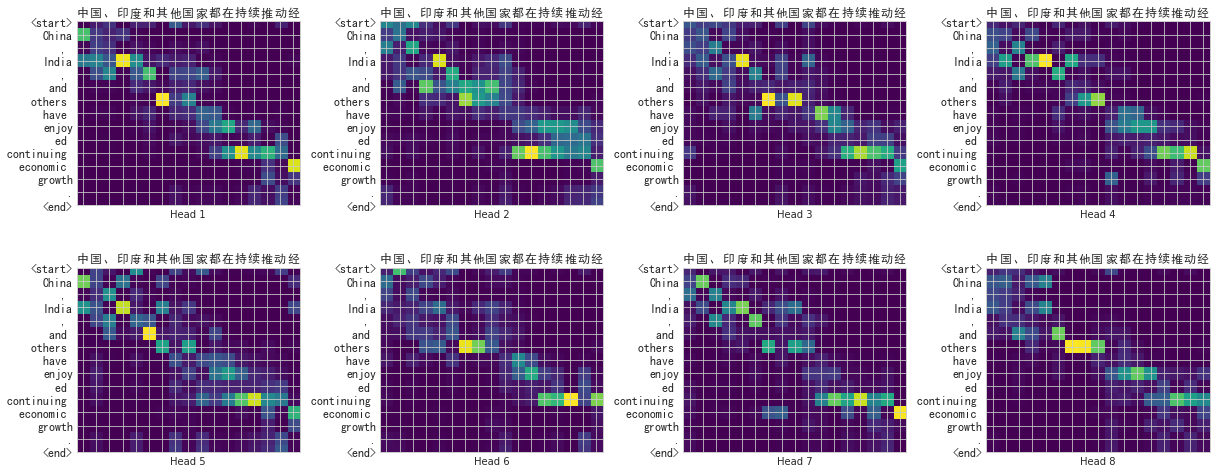

In [81]:
plot_attention_weights(attention_weights, sentence,predicted_seq, layer_name, max_len_tar=18)